In [1]:
import numpy as np
import cupy as cp
from cupyx import jit
import pylab as plt
import time

In [2]:
@jit.rawkernel()
def mykernel(pos, vel, posout, velout):
    row = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x;
    dt = 1;  
    mu = 398600;
    
    xin = pos[row, 0]
    yin = pos[row, 1]
    zin = pos[row, 2]
    vxin = vel[row, 0]
    vyin = vel[row, 1]
    vzin = vel[row, 2]

    posout[row, 0] = xin + dt * vxin
    posout[row, 1] = yin + dt * vyin
    posout[row, 2] = zin + dt * vzin

    r = cp.sqrt(xin*xin + yin*yin + zin*zin)
    ax = - mu * xin / r**3
    ay = - mu * yin / r**3
    az = - mu * zin / r**3
        
    velout[row, 0] = vxin + dt * ax
    velout[row, 1] = vyin + dt * ay
    velout[row, 2] = vzin + dt * az

/home/ubuntu/.local/share/virtualenvs/gpu-integ-test-ASqOnRrh/lib/python3.6/site-packages/cupyx/jit/_interface.py:156: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
# Initialize
npartices = 100_000
nsteps = 100

pos = np.zeros((npartices, 3))
pos[:, 0] = 0
pos[:, 1] = 0
pos[:, 2] = 6378.14 # 1 Re in km
pos = cp.array(pos)

vel = np.zeros((npartices, 3)) 
vel[:, 0] = -7.6  # km/s
vel[:, 1] = 0
vel[:, 2] = 0
vel = cp.array(vel)

posout = cp.zeros(pos.shape)
velout = cp.zeros(vel.shape)

# Define the block and grid dimensions
threads_per_block = 1024
blocks_per_grid = ( (pos.shape[0] + threads_per_block - 1) // threads_per_block, )

In [4]:
assert not np.isnan(pos.get()).any() 
assert not np.isnan(vel.get()).any()

In [5]:
start_time = time.time()

vel_hist = []
pos_hist = []

for i in range(nsteps):
    pos_hist.append(pos.copy().get())
    vel_hist.append(pos.copy().get())
    mykernel(blocks_per_grid, (threads_per_block,), (pos, vel, posout, velout))
    pos = posout.copy()
    vel = velout.copy()
    
vel_hist = np.array(vel_hist)
pos_hist = np.array(pos_hist) /  6378.14

print(f'Took {time.time() - start_time} sec')

Took 0.8866803646087646 sec


Text(0, 0.5, 'Z ($R_E$)')

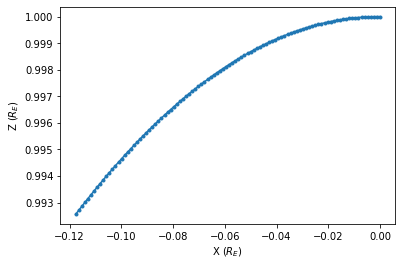

In [6]:
plt.plot(pos_hist[:, 0, 0],
         pos_hist[:, 0, 2],
         '.-')
plt.xlabel('X ($R_E$)')
plt.ylabel('Z ($R_E$)')

Text(0, 0.5, 'Velocity (km/s)')

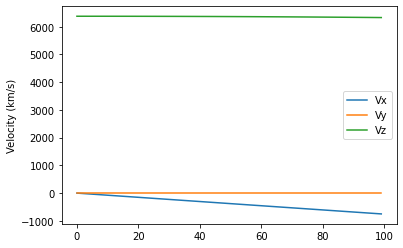

In [7]:
plt.plot(vel_hist[:, 0, 0], label='Vx')
plt.plot(vel_hist[:, 0, 1], label='Vy')
plt.plot(vel_hist[:, 0, 2], label='Vz')
plt.legend()
plt.ylabel('Velocity (km/s)')